# Data prep

In [1]:
import os
path = "/Users/adi/Documents/University/YEAR 4/FYP thesis/Panonut360/dataset/"

In [3]:
import pandas as pd
import os

def load_all_data(base_dir):
    """
    Loads and consolidates data from multiple CSV files into a single DataFrame.
    
    Parameters:
        base_dir (str): The base directory containing subdirectories for each video, 
                        with CSV files for each user.
    
    Returns:
        DataFrame: A consolidated DataFrame containing data from all videos and users.
    """
    # Define an empty list to collect data from each CSV file
    all_data = []
    
    # Loop through each video directory
    for video_id in range(13, 14):  # Assuming video IDs are numbered from 1 to 15
        video_dir = os.path.join(base_dir, f"video_{video_id}")
        
        # Loop through each user's CSV file within the video directory
        for user_id in range(1, 2):  # Assuming user IDs are numbered from 1 to 50
            file_path = os.path.join(video_dir, f"user{user_id}.csv")

        
            
            # Check if the file exists to avoid errors
            if os.path.isfile(file_path):
                # Load the CSV file and handle the PlayerTime parsing
                df = pd.read_csv(file_path)

                df['video_ID'] = video_id
                df['user_ID'] = user_id
                
                # Ensure PlayerTime column has the correct format by trimming whitespace
                df['player_time'] = df['player_time'].str.strip()
                
                # Convert PlayerTime to datetime format
                try:
                    df['player_time'] = pd.to_timedelta(df['player_time'])
                    # df['player_time'] = pd.to_datetime(df['player_time'], format='%H:%M:%S.%f').dt.time
                except ValueError as e:
                    print(f"Error parsing time in file {file_path}: {e}")
                    continue  # Skip this file if there’s an error

                # Calculate elapsed time
                df['Elapsed_Time'] = (df['player_time'] - df['player_time'].iloc[0]).dt.total_seconds()
                
                
                # Append the processed DataFrame to the list
                all_data.append(df)
    
    # Concatenate all data into a single DataFrame
    consolidated_df = pd.concat(all_data, ignore_index=True)
    
    return consolidated_df


In [5]:
consolidated_data = load_all_data(path)

In [451]:
consolidated_data.loc[:20,['player_time','head_pitch','head_yaw','frame']]
consolidated_data['frame']

0           0
1           0
2           0
3           1
4           1
         ... 
21609    6163
21610    6163
21611    6163
21612    6164
21613    6164
Name: frame, Length: 21614, dtype: int64

<Axes: >

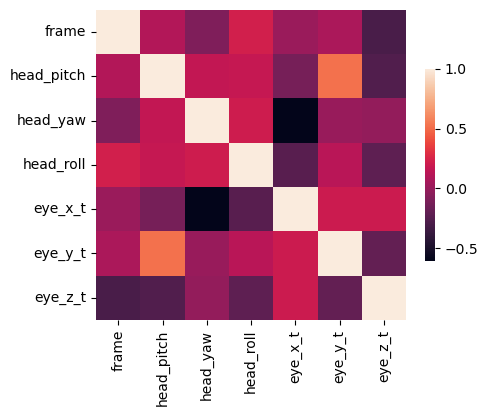

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
features1 = ['head_x', 'head_y', 'head_z', 'eye_c_x', 'eye_c_y', 'eye_c_z', 'eye_x_t', 'eye_y_t', 'eye_z_t', 
            'head_pitch', 'head_yaw', 'head_roll', 'head_quaternion_w', 'head_quaternion_x', 
            'head_quaternion_y', 'head_quaternion_z', 'eye_quaternion_w', 'eye_quaternion_x', 
            'eye_quaternion_y', 'eye_quaternion_z']
features = ['frame','head_pitch', 'head_yaw', 'head_roll', 'eye_x_t', 'eye_y_t', 'eye_z_t']

co_matrix=consolidated_data[features].corr()
plt.figure(figsize=(5,5))
sns.heatmap(co_matrix, square=True, cbar_kws={"shrink": .5})

# LSTM model 

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D
from tensorflow.keras.layers import TimeDistributed, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

# Ensure frame numbers are not normalized
features = ['head_pitch', 'head_yaw', 'head_roll', 'eye_x_t', 'eye_y_t', 'eye_z_t']

# Create a copy of frame column for tracking
df = consolidated_data[:]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


df['frame'] = consolidated_data['frame']

# Define input (X) and output (y) sequences with frame numbers included
sequence_length = 5  # Length of each sequence
def create_sequences_with_frames(df, features, frame_column, sequence_length):
    X, y, frames = [], [], []
    for i in range(len(df) - sequence_length):
        X.append(df[features].iloc[i:i + sequence_length].values)
        y.append(df[features].iloc[i + sequence_length].values)
        frames.append(df[frame_column].iloc[i + sequence_length])  # Track the frame for each y
    return np.array(X), np.array(y), np.array(frames)

X, y, frame_numbers = create_sequences_with_frames(df, features, 'frame', sequence_length)

# Reshape X for ConvLSTM: (samples, time steps, rows, columns, channels)
X = X.reshape((X.shape[0], sequence_length, 1, len(features), 1))
y = y.reshape((y.shape[0], 1, len(features)))

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test, frame_train, frame_test = train_test_split(
    X, y, frame_numbers, test_size=0.2, random_state=50
)

# Build the ConvLSTM model (no changes to the model architecture)
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 3), padding="same", return_sequences=True, 
               input_shape=(sequence_length, 1, len(features), 1)),
    Dropout(0.5),
    ConvLSTM2D(filters=32, kernel_size=(1, 3), padding="same", return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y.shape[-1])
])

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
history = model.fit(
    X_train, y_train, epochs=50, batch_size=1, validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Predict on the test set
predictions = model.predict(X_test)

# Inverse transform to get the original scale for predictions
predictions = scaler.inverse_transform(predictions.reshape(-1, y.shape[-1]))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, y.shape[-1]))

# print(results.head())  # View the first few rows of results

Epoch 1/50


/Users/adi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15558/15558 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - loss: 0.0134 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 2/50
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 104s 7ms/step - loss: 0.0043 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 3/50
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - loss: 0.0035 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/50
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - loss: 0.0032 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 5/50
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 104s 7ms/step - loss: 0.0030 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/50
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - loss: 0.0030 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 7/50
15553/15558 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 99s 6ms/step - loss: 0.0028 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 8/50
15558/15558 ━━━━━━━━━━━━━━━━━━━━ 99s 6ms/step - loss: 0

In [446]:
preds = pd.DataFrame({
    'frame': frame_test,
    'predicted_head_pitch': predictions[:, 0],
    'predicted_head_yaw': predictions[:, 1],
    'predicted_head_roll': predictions[:, 2],
    'predicted_eye_x_t': predictions[:, 3],
    'predicted_eye_y_t': predictions[:, 4],
    'predicted_eye_z_t': predictions[:, 5],# Use the frame numbers from the test set
})
sorted_df = preds.sort_values(by=['frame'], ascending=True)
sorted_df[:]

,frame,predicted_head_pitch,predicted_head_yaw,predicted_head_roll,predicted_eye_x_t,predicted_eye_y_t,predicted_eye_z_t
2275,2,351.284271,230.927063,2.415903,-0.813834,0.082975,-0.519310
2665,4,351.602997,233.405884,2.501633,-0.822167,0.079989,-0.515892
4206,5,351.423523,234.072800,2.518144,-0.827331,0.087796,-0.507282
499,10,352.840240,236.968872,2.691829,-0.841231,0.021823,-0.457232
1563,12,353.433258,242.206116,3.015769,-0.869174,-0.017185,-0.389148
...,...,...,...,...,...,...,...
2432,6160,357.962280,281.465393,3.929520,-0.897379,-0.200389,0.181674
848,6160,357.906311,282.046936,3.928646,-0.893295,-0.198278,0.193512
2236,6161,357.973267,281.110138,3.923431,-0.901189,-0.197387,0.171241
3160,6161,357.972595,280.849640,3.918670,-0.902586,-0.196400,0.167179


In [182]:
orig = pd.DataFrame({
    'frame': frame_test,
    'actual_head_pitch': y_test_original[:,0],
    'actual_head_yaw': y_test_original[:,1],
    'actual_head_roll': y_test_original[:,2],
    'actual_eye_x_t': y_test_original[:,3],
    'actual_eye_y_t': y_test_original[:,4],
    'actual_eye_z_t': y_test_original[:,5]# Use the frame numbers from the test set
})
sorted_df2 = orig.sort_values(by=['frame'], ascending=True)
sorted_df2

,frame,actual_head_pitch,actual_head_yaw,actual_head_roll,actual_eye_x_t,actual_eye_y_t,actual_eye_z_t
2275,2,348.2663,230.9411,8.143003,-0.850409,0.078846,-0.520160
2665,4,348.8381,235.3535,7.092453,-0.845908,0.077996,-0.527565
4206,5,348.8950,236.0829,6.898027,-0.874258,0.020639,-0.484993
499,10,350.3527,245.2538,6.235917,-0.906573,-0.040710,-0.420066
1563,12,353.1008,249.0138,6.224352,-0.901312,-0.072094,-0.427087
...,...,...,...,...,...,...,...
2432,6160,355.8747,286.3622,3.388909,-0.960655,-0.206253,0.186008
848,6160,355.7692,286.8237,3.436026,-0.957132,-0.207839,0.201710
2236,6161,355.9227,286.1007,3.390871,-0.961591,-0.205315,0.182142
3160,6161,355.9557,285.8392,3.400648,-0.961919,-0.208440,0.176749


In [139]:
from sklearn.metrics import r2_score
r_score = r2_score(y_test_original,predictions)
print(r_score)
fit_accuracy = r_score * 100
print(f"Fit Accuracy (R² as percentage): {fit_accuracy:.2f}%")

0.9500197325918466
Fit Accuracy (R² as percentage): 95.00%


In [143]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pred = pd.DataFrame(predictions, columns =['head_pitch', 'head_yaw', 'head_roll','eye_x_t', 'eye_y_t', 'eye_z_t'])
orig = pd.DataFrame(y_test_original, columns =['head_pitch', 'head_yaw', 'head_roll','eye_x_t', 'eye_y_t', 'eye_z_t']) 
# print(pred[:5])
# print(orig[:5])
# print("Actual Values:", y_test_original[:5])

array([[343.253387, 209.361511, 3.463484, -0.492825, 0.223003, -0.833138],
       [353.088287, 124.217766, 5.107285, 0.765391, -0.019378, -0.626749],
       [353.481812, 164.549286, 3.391519, 0.295855, -0.022459, -0.953544],
       ...,
       [15.706190, 91.304749, 3.407899, 0.844138, -0.532841, -0.016338],
       [40.072292, 156.378845, 3.775212, 0.223483, -0.870453, -0.368895],
       [353.910492, 37.867886, 5.152746, 0.654437, -0.206351, 0.709923]],
      dtype=float32)

different parameters 
<i><ul>
- seq length : 5, activation: relu, epcohs: 200, batch size: 32, learningR: 0.001 = 5.03% 
- seq length : 5, activation: relu, epcohs: 50, batch size: 8,  learningR: 0.001  = 20.96% 
- seq length : 5, activation: relu, epcohs: 50, batch size: 4,  learningR: 0.001  = 39.96% 
- seq length : 5, activation: relu, epcohs: 50, batch size: 4,  learningR: 0.003 = 42.43% 
-  seq length : 5, activation: relu, epcohs: 50, batch size: 3,  learningR: 0.003 = 49%
-  seq length : 5, activation: relu, epcohs: 50, batch size: 3,  learningR: 0.003 , dropoutLayers(0.3)= 52% 
- seq length : 5, activation: relu, epcohs: 50, batch size: 3,  learningR: 0.003 , dropoutLayers(0.5)= 54% 
-  seq length : 5, activation: relu, epcohs: 50, batch size: 2,  learningR: 0.003 , dropoutLayers(0.4)= 63.9% 
-  seq length : 5, activation: relu, epcohs: 50, batch size: 2,  learningR: 0.003 , dropoutLayers(0.5)= 67% 
- seq length : 5, activation: relu, epcohs: 50, batch size: 2,  learningR: 0.003 , dropoutLayers(0.5), LR Scheduler (patience:3) = 69.7% 
-  seq length : 5, activation: relu, epcohs: 50, batch size: 2,  learningR: 0.005 , dropoutLayers(0.5), LR Scheduler (patience:3) = 92.37%
<ul></i>

In [149]:
from sklearn.metrics import mean_squared_error
dense_mse1 = mean_squared_error(y_test_original, predictions)
print(f"Model MSE = {dense_mse1:.4f}")
import numpy as np 
MSE = np.square(np.subtract(y_test_original,predictions)).mean()
print(MSE)

Model MSE = 161.9973
161.99726083509248


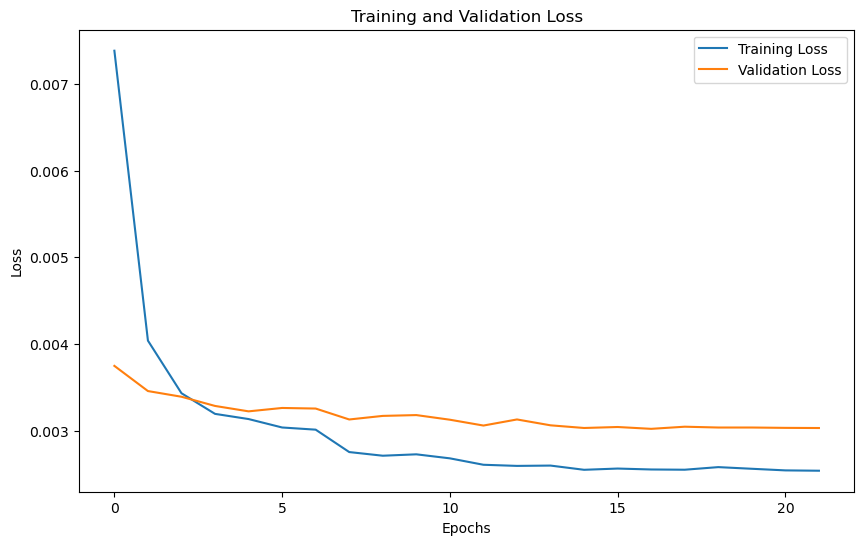

In [135]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Predicted FOV Calculation

In [162]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 19.1 MB/s eta 0:00:0000:0100:01


In [444]:
import cv2
import numpy as np
import pandas as pd
from math import sin, cos, radians



def calculate_fov_trig(head_pitch, head_yaw, eye_direction, video_width, video_height, fov_width=90, fov_height=90):
    """
    Calculate the optimal FOV on the 2D video plane based on head and gaze predictions
    using trigonometric calculations.

    Args:
        head_pitch (float): Predicted head pitch in degrees.
        head_yaw (float): Predicted head yaw in degrees.
        eye_direction (tuple): (eye_x, eye_y, eye_z) in 3D space (normalized vector).
        video_width (int): Width of the video in pixels.
        video_height (int): Height of the video in pixels.
        fov_width (int): Horizontal FOV in degrees (default 90°).
        fov_height (int): Vertical FOV in degrees (default 90°).

    Returns:
        tuple: (top_left, bottom_right) coordinates of the FOV on the video plane.
    """
    # Convert head_pitch and head_yaw from degrees to radians
    pitch_rad = radians(head_pitch)
    yaw_rad = radians(head_yaw)
    
    radius = 1.0

    # Convert spherical coordinates to Cartesian coordinates
    x = radius * cos(yaw_rad) * sin(pitch_rad)  # x-axis component
    y = radius * sin(yaw_rad) * sin(pitch_rad)  # y-axis component
    z = radius * cos(pitch_rad)                # z-axis component)               

    # Adjust for gaze direction by adding eye_direction (normalized vector)
    eye_x, eye_y, eye_z = eye_direction
    gaze_x = x + eye_x
    gaze_y = y + eye_y
    gaze_z = z + eye_z

    # Normalize the gaze vector to prevent scaling issues
    # norm = np.sqrt(gaze_x**2 + gaze_y**2 + gaze_z**2)
    # gaze_x /= norm
    # gaze_y /= norm
    # gaze_z /= norm

    # Map normalized Cartesian coordinates to 2D video plane
    center_x = int(video_width / 2 + gaze_x * video_width / 2)
    center_y = int(video_height / 2 - gaze_y * video_height / 2)  # Flip y-axis to match video plane

    # Map FOV size in degrees to pixels
    fov_width_px = int((fov_width / 360) * video_width)
    fov_height_px = int((fov_height / 180) * video_height)

    # Define FOV rectangle 
    top_left = (max(0, center_x - fov_width_px // 2), max(0, center_y - fov_height_px // 2))
    bottom_right = (min(video_width, center_x + fov_width_px // 2), min(video_height, center_y + fov_height_px // 2))

    return top_left, bottom_right

def overlay_fov_on_frame(video_path, frame_number, fov_coordinates):
    """
    Overlay the computed FOV on the specified frame from the video.

    Args:
        video_path (str): Path to the raw MP4 video file.
        frame_number (int): Frame number to extract and process.
        fov_coordinates (tuple): (top_left, bottom_right) coordinates of the FOV.

    Returns:
        np.ndarray: The frame with the overlaid FOV rectangle.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()
    if not ret:
        raise ValueError(f"Frame {frame_number} could not be read from video.")


    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (0, 255, 0)  # Green color 
    thickness = 2

    # Add frame number to the image (top-left corner)
    text = f"Frame: {frame_number}"
    text_position = (10, 30)  # Coordinates for the text
    cv2.putText(frame, text, text_position, font, font_scale, font_color, thickness)

    # Draw the FOV rectangle on the frame
    top_left, bottom_right = fov_coordinates
    color = (0, 255, 0)  # Green for FOV
    thickness = 2
    frame_with_fov = cv2.rectangle(frame, top_left, bottom_right, color, thickness)

    cap.release()

    return frame_with_fov

def process_video_fov(video_path, frame_number, predictions_df, video_width, video_height):
    """
    Main function to compute the optimal FOV and overlay it on a video frame.

    Args:
        video_path (str): Path to the raw MP4 video file.
        frame_number (int): Frame number to extract and process.
        predictions_df (pd.DataFrame): DataFrame containing predicted data with frame numbers.
        video_width (int): Width of the video in pixels.
        video_height (int): Height of the video in pixels.

    Returns:
        tuple: (FOV in Cartesian coordinates, frame with FOV overlaid).
    """
    # Get predictions for the specified frame
    row = predictions_df[predictions_df['frame'] == frame_number]
    if row.empty:
        raise ValueError(f"No predictions found for frame {frame_number}.")
    
    head_pitch = row['predicted_head_pitch'].values[0]
    head_yaw = row['predicted_head_yaw'].values[0]
    eye_direction = (
        row['predicted_eye_x_t'].values[0],
        row['predicted_eye_y_t'].values[0],
        row['predicted_eye_z_t'].values[0]
    )

    # Calculate the optimal FOV
    fov_coordinates = calculate_fov_trig(head_pitch, head_yaw, eye_direction, video_width, video_height)

    # Overlay FOV on the frame
    frame_with_fov = overlay_fov_on_frame(video_path, frame_number, fov_coordinates)

    return fov_coordinates, frame_with_fov

# Example Usage
video_path = '/Users/adi/Documents/University/YEAR 4/FYP thesis/videos/Surfing.mp4'
frame_number = 3121 
video_width = 4319 
video_height = 1920

# Predictions DataFrame 
predictions_df = sorted_df

# Process the video and compute FOV
fov_coordinates, frame_with_fov = process_video_fov(video_path, frame_number, predictions_df, video_width, video_height)

# Save the frame with the FOV overlaid
output_frame_path = 'frame_with_fov6.jpg'
cv2.imwrite(output_frame_path, frame_with_fov)

# Print the FOV in Cartesian coordinates
print("FOV Coordinates (Cartesian):", fov_coordinates) #topleft and bottom right cartesian coordinates. 


FOV Coordinates (Cartesian): ((2614, 287), (3692, 1247))


In [442]:
result = sorted_df[sorted_df['frame'] == 3121]
result

,frame,predicted_head_pitch,predicted_head_yaw,predicted_head_roll,predicted_eye_x_t,predicted_eye_y_t,predicted_eye_z_t
1744,3121,343.515808,164.816986,3.651035,0.186237,0.274866,-0.922612
3604,3121,343.523254,166.164581,3.591718,0.166758,0.271499,-0.929885
